# SQL in Pandas with SQLAlchemy

We will use the "sshtunnel" library to connect to our remote AWS instance and then pull some data into Pandas using SQLAlchemy and Pyscopg2.

## Creating the SSH Tunnel

The "sshtunnel" library can read an SSH config file, so creating a tunnel is quite easy assuming SSH keys are setup and the SSH config entry has been created. With this setup, the "sshtunnel" library automatically determines what the address of the local port should be.

If you are having problems with the password on SSH , in command line type:

    '''ssh-keygen -p'''
    
- First prompt is directory of key, if the guess is correct then hit enter
- Enter your old passpharse
- Enter nothing for the new passphrase
- You should then be able to tunnel / connect to AWS without a passphrase prompt

https://stackoverflow.com/questions/112396/how-do-i-remove-the-passphrase-for-the-ssh-key-without-having-to-create-a-new-ke

In [1]:
from sshtunnel import SSHTunnelForwarder

AWS_IP_ADDRESS = '54.202.1.103'
AWS_USERNAME = 'leo2506'
SSH_KEY_PATH = '/Users/liuriguang/.ssh/id_rsa'

server = SSHTunnelForwarder(
    AWS_IP_ADDRESS,
    ssh_username=AWS_USERNAME,
    ssh_pkey=SSH_KEY_PATH,
    remote_bind_address=('localhost', 5432),
)

server.start()
print(server.is_active, server.is_alive, server.local_bind_port)

True True 61813


##  Connecting via Python
We'll be using a Psycopg2 connector alongside SQLAlchemy to connect to this database.

* **SQLAlchemy:** generates SQL statements
* **Psycopg2:** sends the SQL statements to the Postgres database

    Let's make the connection to the database. Note that the IP address of the Postgres database is 'localhost' and the port is set to whatever the `server` connection above contains. This is because we have used the SSH tunnel to create a connection between the AWS instance and our computer. SSH tunnels enable remote instances to behave as if they are *local*.

In [2]:
from sqlalchemy import create_engine

# Postgres username, password, and database name
POSTGRES_IP_ADDRESS = 'localhost' ## This is localhost because SSH tunnel is active
POSTGRES_PORT = str(server.local_bind_port)
POSTGRES_USERNAME = 'leo2506'     ## CHANGE THIS TO YOUR POSTGRES USERNAME
POSTGRES_PASSWORD = 'leo2506' ## CHANGE THIS TO YOUR POSTGRES PASSWORD
POSTGRES_DBNAME = 'baseball'

# A long string that contains the necessary Postgres login information
postgres_str = ('postgresql://{username}:{password}@{ipaddress}:{port}/{dbname}'
                .format(username=POSTGRES_USERNAME, 
                        password=POSTGRES_PASSWORD,
                        ipaddress=POSTGRES_IP_ADDRESS,
                        port=POSTGRES_PORT,
                        dbname=POSTGRES_DBNAME))

# Create the connection
cnx = create_engine(postgres_str)

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cross_validation import KFold
from sklearn.preprocessing import StandardScaler


%config InlineBackend.figure_format = 'svg'
%matplotlib inline

# Challenge Set 9
## Part II: Baseball Data

1. What was the total spent on salaries by each team, each year?

In [5]:
pd.read_sql_query('''SELECT * FROM Salaries LIMIT 5;''', cnx)

,yearid,teamid,lgid,playerid,salary
0,1985,BAL,AL,murraed02,1472819.0
1,1985,BAL,AL,lynnfr01,1090000.0
2,1985,BAL,AL,ripkeca01,800000.0
3,1985,BAL,AL,lacyle01,725000.0
4,1985,BAL,AL,flanami01,641667.0


In [6]:
sql_query = '''SELECT teamid, yearid, round(SUM(salary)/1000000) Total_Spent_Millions 
               FROM Salaries
               GROUP BY teamid, yearid
               ORDER BY 1,2;'''

pd.read_sql_query(sql_query, cnx)

,teamid,yearid,total_spent_millions
0,ANA,1997,31.0
1,ANA,1998,41.0
2,ANA,1999,55.0
3,ANA,2000,51.0
4,ANA,2001,48.0
5,ANA,2002,62.0
6,ANA,2003,79.0
7,ANA,2004,101.0
8,ARI,1998,32.0
9,ARI,1999,69.0


2. What is the first and last year played for each player? *Hint:* Create a new table from 'Fielding.csv'.

In [7]:
sql_query = '''SELECT playerid, MIN(yearid) first_year, MAX(yearid) last_year
               FROM fielding
               GROUP BY playerid
               ORDER BY 1;'''

pd.read_sql_query(sql_query, cnx)

,playerid,first_year,last_year
0,aardsda01,2004,2013
1,aaronha01,1954,1976
2,aaronto01,1962,1971
3,aasedo01,1977,1990
4,abadan01,2001,2003
5,abadfe01,2010,2013
6,abadijo01,1875,1875
7,abbated01,1897,1910
8,abbeybe01,1892,1896
9,abbeych01,1893,1897


3. Who has played the most all star games?

In [8]:
sql_query = '''SELECT playerid, COUNT(DISTINCT gameid) total_games
               FROM allstarfull
               GROUP BY playerid
               ORDER BY 2 DESC LIMIT 1;'''

pd.read_sql_query(sql_query, cnx)

,playerid,total_games
0,aaronha01,25


4. Which school has generated the most distinct players? *Hint:* Create new table from 'CollegePlaying.csv'.

In [9]:
sql_query = '''SELECT sp.schoolid, schoolname, COUNT(DISTINCT playerid) total_players
               FROM schoolsplayers sp JOIN schools s
               ON sp.schoolid = s.schoolid
               GROUP BY 1,2
               ORDER BY 3 DESC LIMIT 1;'''

pd.read_sql_query(sql_query, cnx)

,schoolid,schoolname,total_players
0,usc,University of Southern California,102


5. Which players have the longest career? Assume that the `debut` and `finalGame` columns comprise the start and end, respectively, of a player's career. *Hint:* Create a new table from 'Master.csv'. Also note that strings can be converted to dates using the [`DATE`](https://wiki.postgresql.org/wiki/Working_with_Dates_and_Times_in_PostgreSQL#WORKING_with_DATETIME.2C_DATE.2C_and_INTERVAL_VALUES) function and can then be subtracted from each other yielding their difference in days.

In [21]:
sql_command = '''
ALTER TABLE master 
ALTER COLUMN debut DROP NOT NULL,
ALTER COLUMN finalgame DROP NOT NULL
'''

cnx.execute(sql_command)

In [27]:
sql_command = '''
COPY master FROM PROGRAM 'cut -d "," -f 1,21,22 /home/leo2506/baseballdata/Master.csv' DELIMITER ',' CSV HEADER;
'''

cnx.execute(sql_command)

In [39]:
sql_query = '''SELECT playerid, DATE(finalgame) - DATE(debut) career
               FROM master
               WHERE finalgame is NOT NULL 
               AND debut is NOT NULL
               ORDER BY 2 DESC
               LIMIT 1;'''

pd.read_sql_query(sql_query, cnx)

,playerid,career
0,altroni01,12862


6. What is the distribution of debut months? *Hint:* Look at the `DATE` and [`EXTRACT`](https://www.postgresql.org/docs/current/static/functions-datetime.html#FUNCTIONS-DATETIME-EXTRACT) functions.

In [45]:
sql_query = '''SELECT EXTRACT(MONTH FROM DATE(debut)) debut_month, COUNT(EXTRACT(MONTH FROM DATE(debut))) freq
               FROM master
               WHERE debut is NOT NULL
               GROUP BY 1
               ORDER BY 1;'''

df = pd.read_sql_query(sql_query, cnx)
df

,debut_month,freq
0,3.0,41
1,4.0,4711
2,5.0,2230
3,6.0,1893
4,7.0,1978
5,8.0,1943
6,9.0,5061
7,10.0,308


<BarContainer object of 8 artists>

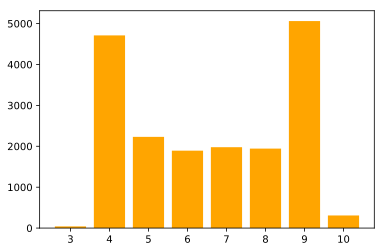

In [51]:
plt.bar(df.debut_month,df.freq,color='orange')

7. What is the effect of table join order on mean salary for the players listed in the main (master) table? *Hint:* Perform two different queries, one that joins on playerID in the salary table and other that joins on the same column in the master table. You will have to use left joins for each since right joins are not currently supported with SQLalchemy.

In [60]:
sql_query = '''SELECT s.playerid, ROUND(AVG(salary)) mean_salary
            FROM salaries s LEFT JOIN master m
            ON s.playerid = m.playerid
            GROUP BY 1
            ORDER BY 2 DESC
            ;'''

pd.read_sql_query(sql_query, cnx) 

,playerid,mean_salary
0,rodrial01,17770813.0
1,jeterde01,14034338.0
2,teixema01,13229545.0
3,howarry01,13156875.0
4,sabatcc01,12303571.0
5,kurodhi01,12010954.0
6,suzukic01,11817806.0
7,zambrca01,11495000.0
8,soriaal01,10920000.0
9,ramirma02,10885672.0


In [61]:
sql_query = '''SELECT m.playerid, ROUND(AVG(salary)) mean_salary
            FROM master m LEFT JOIN salaries s
            ON s.playerid = m.playerid
            GROUP BY 1
            ORDER BY 2 DESC
            ;'''

pd.read_sql_query(sql_query, cnx) 

,playerid,mean_salary
0,martisp01,NaN
1,ramospe01,NaN
2,putkolu01,NaN
3,boyerke01,NaN
4,dillibo01,NaN
5,lipscni01,NaN
6,pezolla01,NaN
7,donalat01,NaN
8,kimsech01,NaN
9,cample01,NaN


## Load Some Data!

Pandas has a `read_sql_query` method that will pass a SQL statement to a database connection. Here is an example from the all-star table.

In [3]:
import pandas as pd

pd.read_sql_query('''SELECT * FROM allstarfull LIMIT 5;''', cnx)

,playerid,yearid,gamenum,gameid,teamid,lgid,gp,startingpos
0,gomezle01,1933,0,ALS193307060,NYA,AL,1,1
1,ferreri01,1933,0,ALS193307060,BOS,AL,1,2
2,gehrilo01,1933,0,ALS193307060,NYA,AL,1,3
3,gehrich01,1933,0,ALS193307060,DET,AL,1,4
4,dykesji01,1933,0,ALS193307060,CHA,AL,1,5


And another from the schools table.

In [4]:
pd.read_sql_query('''SELECT * FROM schools LIMIT 5;''', cnx)

,schoolid,schoolname,schoolcity,schoolstate,schoolnick
0,abilchrist,Abilene Christian University,Abilene,TX,Wildcats
1,adelphi,Adelphi University,Garden City,NY,Panthers
2,adrianmi,Adrian College,Adrian,MI,Bulldogs
3,airforce,United States Air Force Academy,Colorado Springs,CO,Falcons
4,akron,University of Akron,Akron,OH,Zips


More sophisticated queries can also be used. This example finds the states with the most schools.

In [5]:
sql_query = '''SELECT schoolstate as state, Count(schoolid) as ct 
               FROM schools 
               GROUP BY state 
               ORDER BY ct DESC 
               LIMIT 5;'''

pd.read_sql_query(sql_query, cnx)

,state,ct
0,PA,57
1,CA,48
2,NY,45
3,TX,41
4,OH,33


Finally, this example finds five players from the year 1985 whose salary was above $500,000.

In [6]:
sql_query = '''SELECT playerid, salary 
               FROM Salaries 
               WHERE yearid = '1985' AND salary > '500000'
               ORDER BY salary DESC
               LIMIT 5;'''

pd.read_sql_query(sql_query, cnx)

,playerid,salary
0,schmimi01,2130300.0
1,cartega01,2028571.0
2,fostege01,1942857.0
3,winfida01,1795704.0
4,gossari01,1713333.0


## Close Server Connection

Finally, we should close the server connection when complete.

In [7]:
server.close()